# Import required libraries

In [ ]:
import os
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

from IPython import display
from IPython.display import clear_output

%matplotlib inline

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install pydot
!pip install graphviz
!pip install pydotplus


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.applications import ResNet50


print(tf.__version__) # Check the version of tensorflow used



2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Aerial_Semantic_Segmentation/semantic_drone_dataset/training_set'

# Define directories for images and masks
image_dir = data_path + '/images'
mask_dir = data_path + '/gt/semantic/label_images'

# Get all image and mask files
all_image_path = glob.glob(f"{image_dir}/*.jpg")
all_mask_path = glob.glob(f"{mask_dir}/*.png")

all_image_path.sort()
all_mask_path.sort()

# Data Visualization

In [ ]:
IM_SHOW_SIZE = 10

# Print the number of images and masks
print(f"Total number of images: {len(all_image_path)}")
print(f"Total number of masks: {len(all_mask_path)}")
# Plot the images and masks side by side
plt.figure(figsize=(10, (IM_SHOW_SIZE / 2) * 6))
for i in range(0, IM_SHOW_SIZE):
    idx = random.randint(0, len(all_image_path) - 1)
    image_file = all_image_path[idx]
    mask_file = all_mask_path[idx]


    # Open image and corresponding mask
    image = Image.open(image_file)
    mask = Image.open(mask_file)

    # Plot the image
    ax = plt.subplot(10, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image: {os.path.basename(image_file)}")


    # Plot the corresponding mask
    ax = plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask)
    plt.title(f"Mask: {os.path.basename(mask_file)}")


plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Create Training / Validation / Testset

In [ ]:
devset_image_path, testset_image_path, devset_mask_path, testset_mask_path  = train_test_split(
    all_image_path, all_mask_path, test_size=0.2, random_state=42)

trainset_image_path , val_image_path , trainset_mask_path, val_mask_path   = train_test_split(
    devset_image_path, devset_mask_path, test_size=0.2, random_state=42)

print(f"Number of training images: {len(trainset_image_path)}")
print(f"Number of validation images: {len(val_image_path)}")
print(f"Number of test images: {len(testset_image_path)}")

Number of training images: 256
Number of validation images: 64
Number of test images: 80


# Create Tensorflow Dataset

In [ ]:
def extract_patches(image, mask, patch_size=128):
    """
    Extracts patches from images and corresponding masks.
    Args:
        image: A tensor representing the input RGB image.
        mask: A tensor representing the segmentation mask (single channel).
        patch_size: The size of the patches (default: 128x128).
    Returns:
        A tuple of (image_patches, mask_patches).
    """
    # Convert images and masks to 4D tensors (add batch dimension)
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)

    # Extract patches from the images
    image_patches = tf.image.extract_patches(
        images=image,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'  # or 'SAME' depending on desired behavior
    )

    # Extract patches from the masks
    mask_patches = tf.image.extract_patches(
        images=mask,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'  # or 'SAME' depending on desired behavior
    )

    # Remove the batch dimension from the patches
    image_patches = tf.squeeze(image_patches, axis=0)
    mask_patches = tf.squeeze(mask_patches, axis=0)

    # Reshape the image patches to have the shape: (num_patches, patch_size, patch_size, 3)
    image_patches = tf.reshape(image_patches, [-1, patch_size, patch_size, 3])  # RGB images

    # Reshape the mask patches to have the shape: (num_patches, patch_size, patch_size, 1)
    mask_patches = tf.reshape(mask_patches, [-1, patch_size, patch_size, 1])  # Single-channel masks

    return image_patches, mask_patches

def load_and_preprocess(image_path, mask_path, patch_size=128):
    """
    Loads and preprocesses an image and its corresponding mask.
    """
    # Load the image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # # Cast image to float32 and normalize pixel values to [0, 1]
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Use tf.py_function to load mask using numpy
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    # Extract patches from both image and mask
    image_patches, mask_patches = extract_patches(image, mask, patch_size)

    return image_patches, mask_patches

def create_dataset(image_paths, masks, patch_size=128):
    """
    Create a TensorFlow dataset from image paths and corresponding masks.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, masks))

    # Apply the load_and_preprocess function
    dataset = dataset.map(lambda img_path, mask: load_and_preprocess(img_path, mask, patch_size),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Flatten the patches so each entry is a pair of (image_patch, mask_patch)
    dataset = dataset.flat_map(lambda image_patches, mask_patches: tf.data.Dataset.from_tensor_slices((image_patches, mask_patches)))

    return dataset

In [ ]:
# Create the dataset
train_ds = create_dataset(trainset_image_path, trainset_mask_path, patch_size=128)
val_ds = create_dataset(val_image_path, val_mask_path, patch_size=128)


In [ ]:
for image_patches, mask_patches in train_ds:
        print("Image patches dtype:", image_patches.dtype)
        print("Image patches shape:", image_patches.shape)

        print("Mask patches dtype:", mask_patches.dtype)
        print("Mask patches shape:", mask_patches.shape)
        break

Image patches dtype: <dtype: 'uint8'>
Image patches shape: (128, 128, 3)
Mask patches dtype: <dtype: 'uint8'>
Mask patches shape: (128, 128, 1)


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
TRAIN_LENGTH = len(trainset_image_path)
BATCH_SIZE = 64
BUFFER_SIZE = 1000


In [ ]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

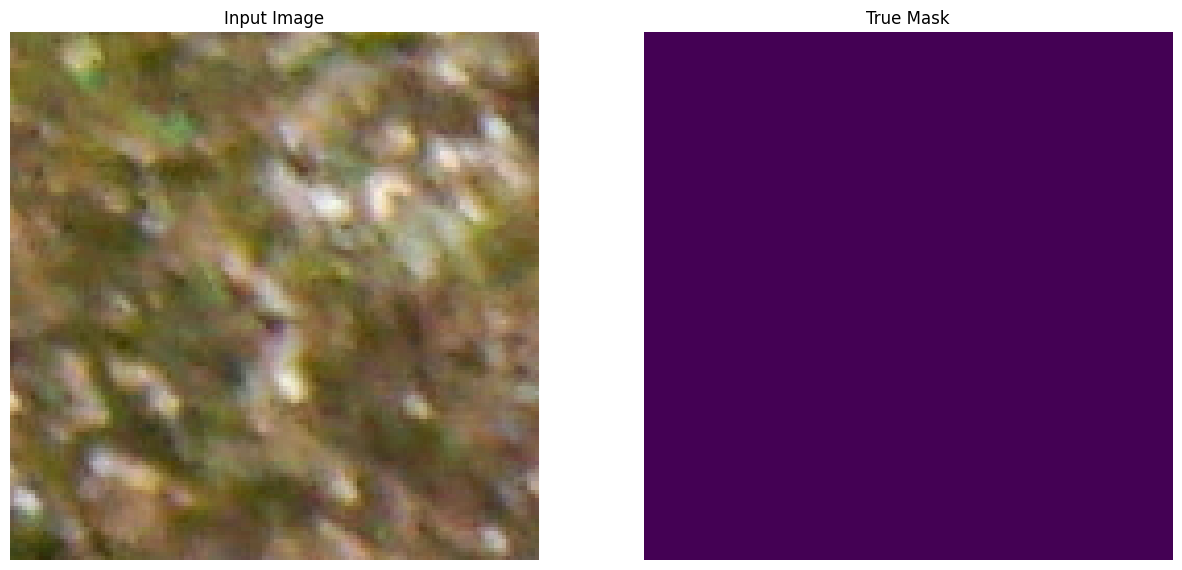

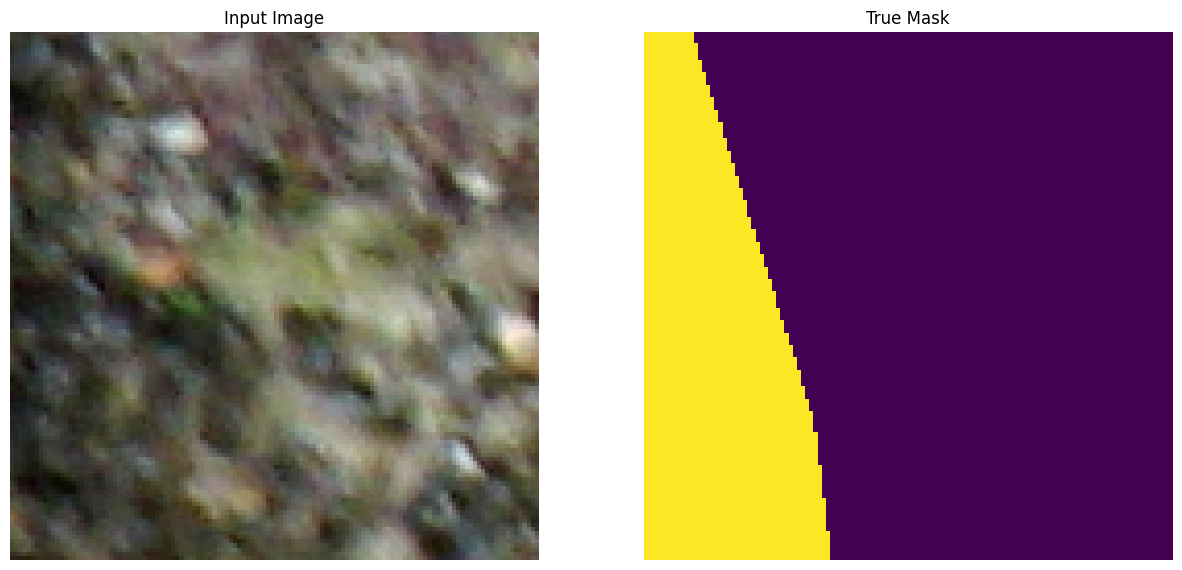

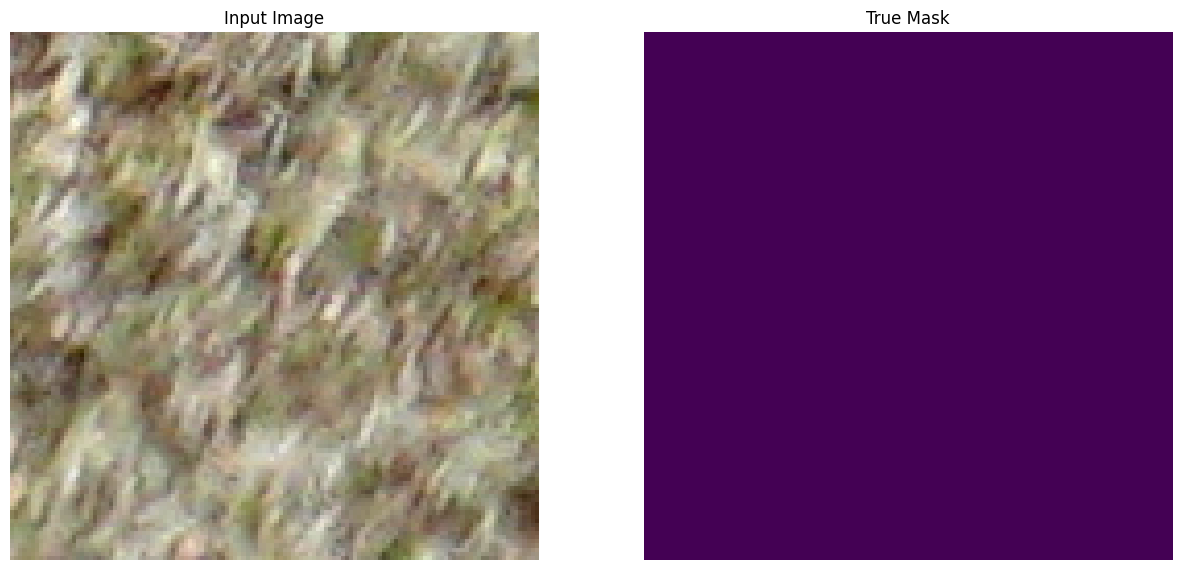

In [ ]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# MobileNetV2 model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
# Custom layer for type casting
class CastToFloat32(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Use custom layer to convert to float32
  x = CastToFloat32()(inputs)
  # Normalize input images to the range [0, 1]
  x = tf.keras.layers.Rescaling(1./255)(x)

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [ ]:
OUTPUT_CLASSES = 255

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 56ms/step


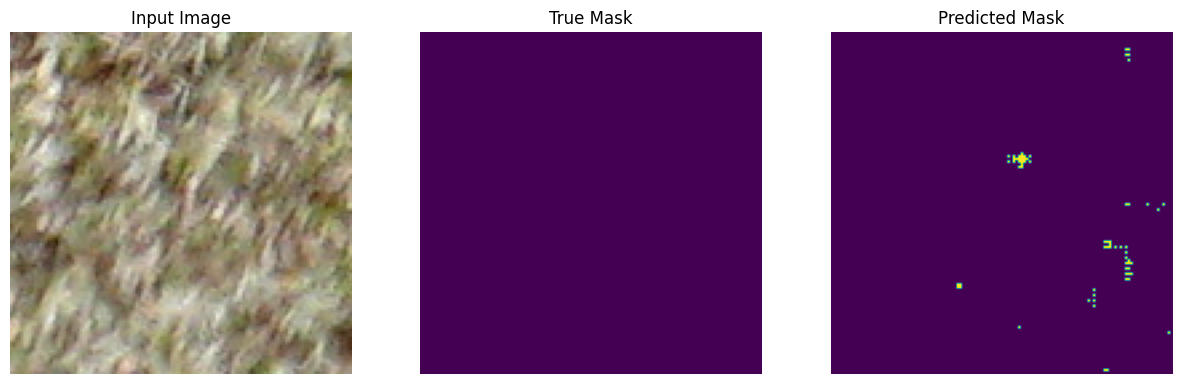


Sample Prediction after epoch 30

4/4 [==============================] - 18s 5s/step - loss: 0.6111 - accuracy: 0.8270 - val_loss: 4.4854 - val_accuracy: 0.1972


In [ ]:
EPOCHS = 30
VALIDATION_STEPS = len(val_image_path) // BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

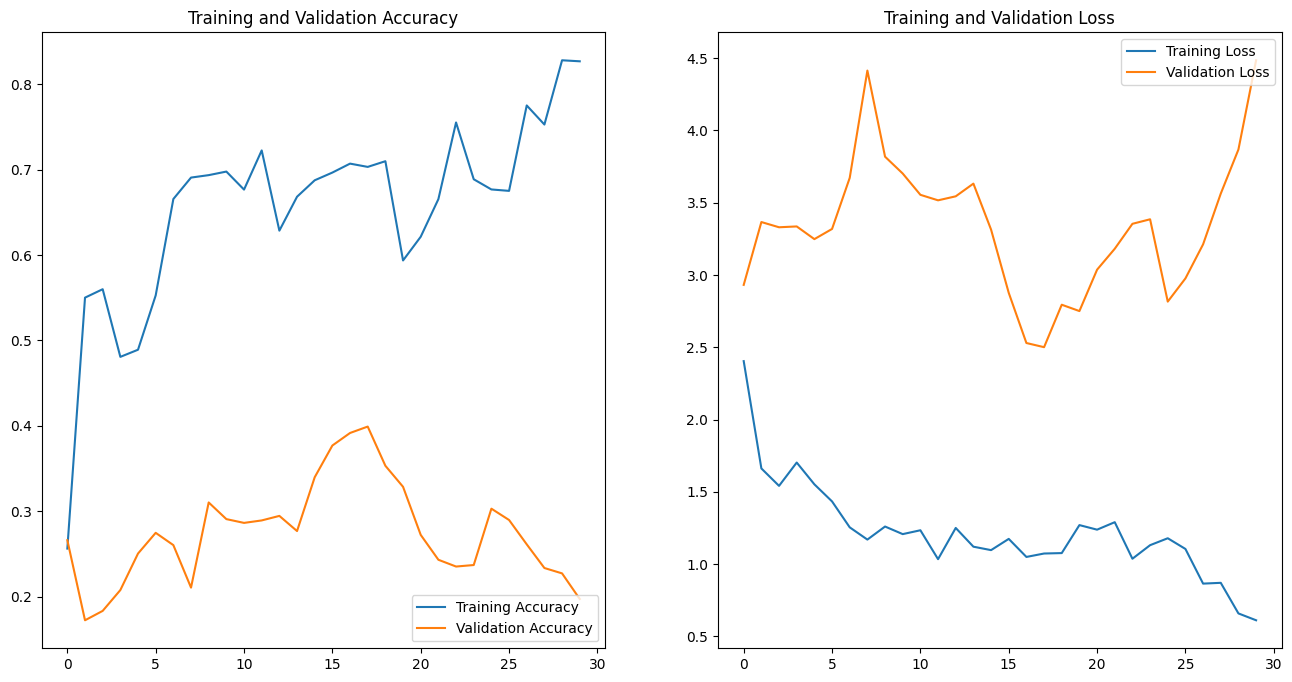

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet50 Model

In [ ]:
def improved_unet(input_shape=(256, 256, 3), num_classes=255):
    inputs = Input(input_shape)

    # Encoder (Using ResNet50 as backbone)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False
    skip_connections = [
        base_model.get_layer("conv1_conv").output,
        base_model.get_layer("conv2_block3_out").output,
        base_model.get_layer("conv3_block4_out").output,
        base_model.get_layer("conv4_block6_out").output,
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output

    # Decoder
    x = encoder_output
    for i, skip in enumerate(reversed(skip_connections)):
        x = Conv2DTranspose(512 // (2**i), (3, 3), strides=(2, 2), padding="same")(x)
        x = Concatenate()([x, skip])
        x = Dropout(0.5)(x)
        x = Conv2D(512 // (2**i), (3, 3), activation="relu", padding="same")(x)
        x = BatchNormalization()(x)

    # Ensure the final layer upsamples to 256x256
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)  # Extra upsampling layer
    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
train_ds = create_dataset(trainset_image_path, trainset_mask_path, patch_size=256)
val_ds = create_dataset(val_image_path, val_mask_path, patch_size=256)

In [ ]:
for image_patches, mask_patches in train_ds:
        print("Image patches dtype:", image_patches.dtype)
        print("Image patches shape:", image_patches.shape)

        print("Mask patches dtype:", mask_patches.dtype)
        print("Mask patches shape:", mask_patches.shape)
        break

Image patches dtype: <dtype: 'uint8'>
Image patches shape: (256, 256, 3)
Mask patches dtype: <dtype: 'uint8'>
Mask patches shape: (256, 256, 1)


In [ ]:
TRAIN_LENGTH = len(trainset_image_path)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)

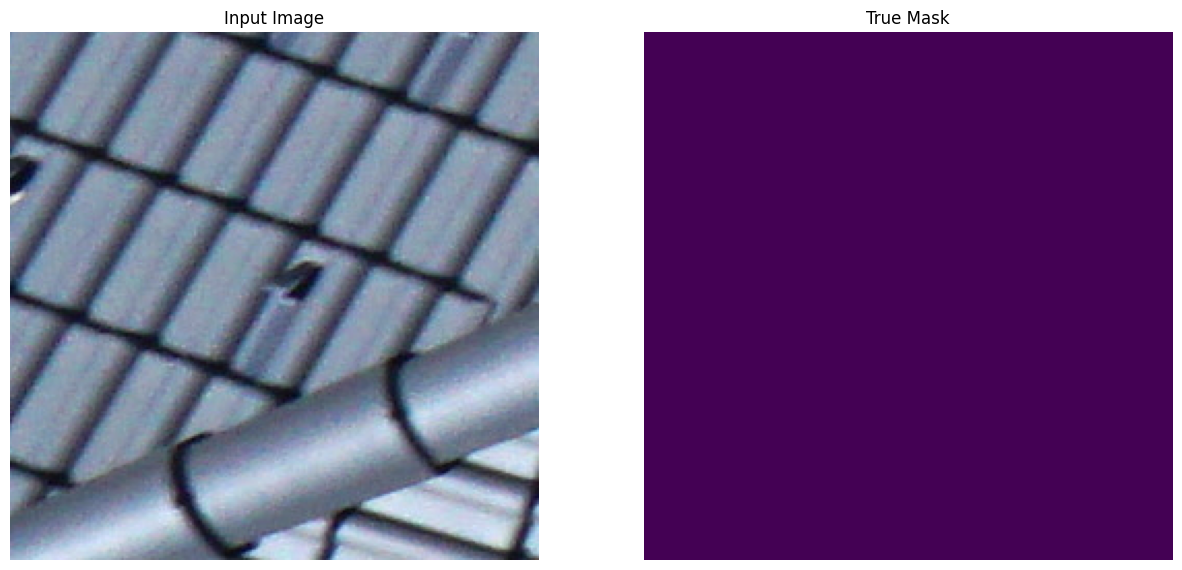

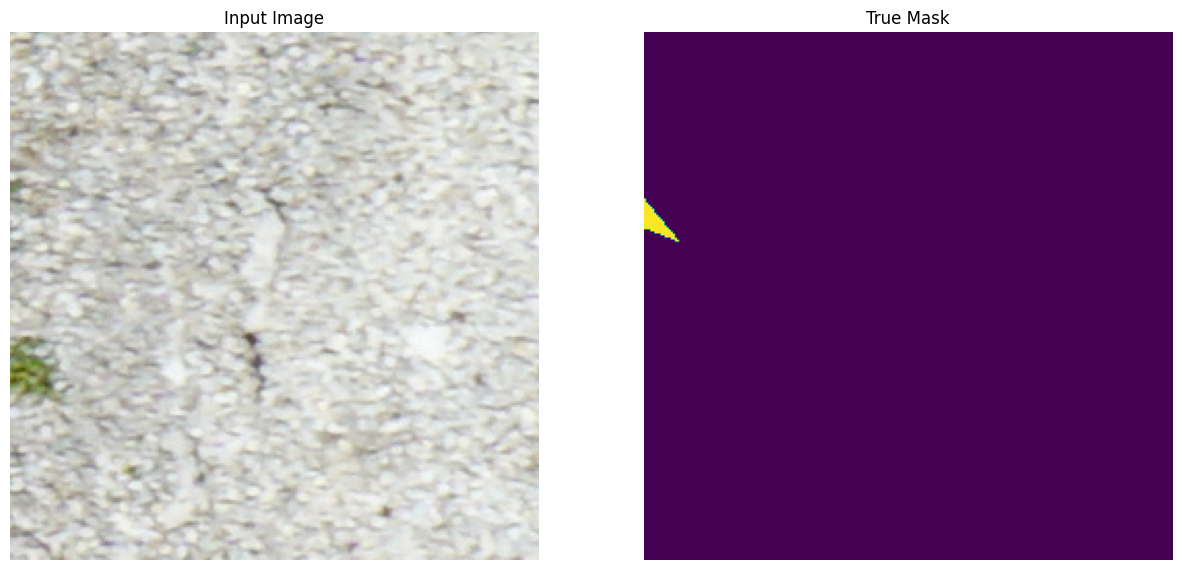

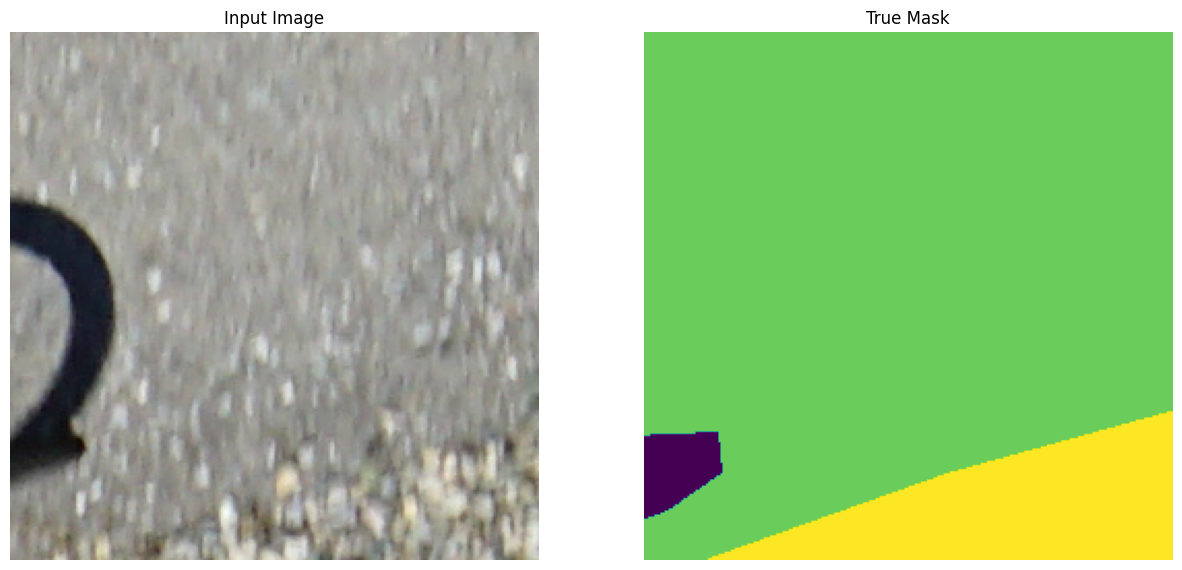

In [ ]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
# Instantiate the model
OUTPUT_CLASSES = 226
model = improved_unet(input_shape=(256, 256, 3), num_classes=OUTPUT_CLASSES)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', tf.keras.metrics. SparseCategoricalAccuracy()]
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
EPOCHS = 30
VALIDATION_STEPS = len(val_image_path) // BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

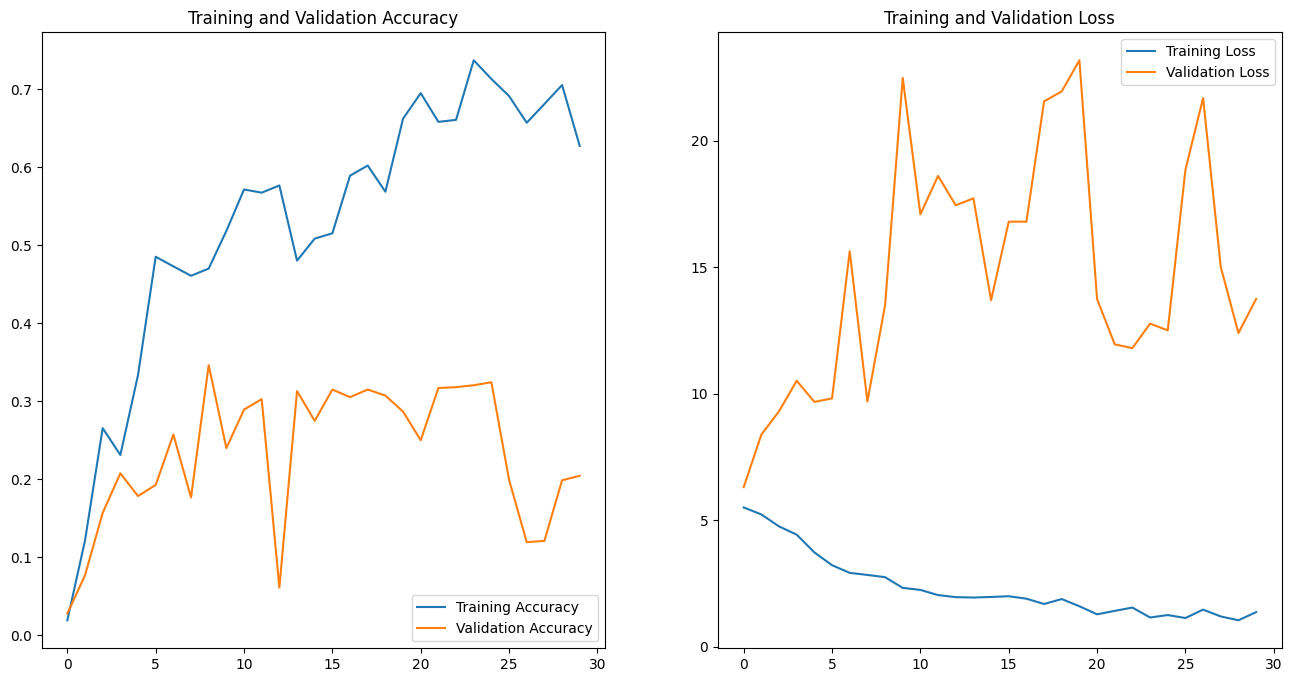

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()